# 분석에 필요한 라이브러리 설치

In [ ]:
# # 필요한 라이브러리 설치
#!pip install plotnine kmodes tqdm ipypb

In [2]:
import sqlite3
import pandas as pd
import numpy as np

In [3]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
from plotnine import *
import plotnine

In [5]:
from sklearn.preprocessing import MinMaxScaler
from kmodes.kprototypes import KPrototypes

In [6]:
from tqdm import tqdm_notebook
import time
from ipypb import ipb

In [7]:
# 경고 메세지 안보이게 설정
import warnings
warnings.filterwarnings('ignore')

# 분석할 테이블 불러오기

In [8]:
# 영수증 번호가 E인 것들 select + 1번 + 5번 연결
con = sqlite3.connect("database/lpoint.db", isolation_level=None) # lpoint db 생성 or 연결

df2 = pd.read_sql('''
SELECT P.cust, D.ma_fem_dv, D.ages, D.zon_hlv, P.rct_no, P.de_dt, P.chnl_dv, P.cop_c, P.pd_c, C.clac_hlv_nm, C.clac_mcls_nm, C.pd_nm, P.de_hr, P.buy_am, P.buy_ct
FROM PDDE AS P, DEMO AS D, PD_CLAC AS C
WHERE P.cust = D.cust AND P.pd_c = C.pd_c AND P.chnl_dv = 1
GROUP BY P.cust, D.ma_fem_dv, D.ages, D.zon_hlv, P.rct_no, P.de_dt, P.chnl_dv, P.cop_c, P.pd_c, C.clac_hlv_nm, C.clac_mcls_nm, C.pd_nm, P.de_hr, P.buy_am, P.buy_ct;
''', con, index_col=None)

con.close()

# 불러온 테이블 컬럼명 한글로 재설정

In [9]:
df2.columns = ['고객번호', '성별', '연령대', '거주지분류대코드', '영수증번호', '구매일자', '채널구분', '제휴사', 
              '상품코드', '상품대분류명', '상품중분류명', '상품소분류명',
              '구매시간', '구매금액', '구매수량']

In [10]:
df2.head()

,고객번호,성별,연령대,거주지분류대코드,영수증번호,구매일자,채널구분,제휴사,상품코드,상품대분류명,상품중분류명,상품소분류명,구매시간,구매금액,구매수량
0,M000034966,여성,40대,Z07,A01016688590,20210116,1,A01,PD0777,스포츠패션,남성스포츠화,남성런닝/트레이닝화,18,19000,1
1,M000034966,여성,40대,Z07,A01016688590,20210116,1,A01,PD0777,스포츠패션,남성스포츠화,남성런닝/트레이닝화,18,59000,1
2,M000034966,여성,40대,Z07,A01016688590,20210116,1,A01,PD0796,스포츠패션,스포츠잡화,스포츠아대/헤어밴드,18,100,1
3,M000034966,여성,40대,Z07,A01016718167,20210116,1,A01,PD0816,스포츠패션,여성스포츠화,여성런닝/트레이닝화,18,62100,1
4,M000034966,여성,40대,Z07,A02357398521,20210325,1,A02,PD0616,속옷/양말/홈웨어,남성속옷,남성팬티,13,5000,1


# 랜덤추출하기

In [13]:
## 연속된 인덱스의 중복값 때문에 인덱스 셔플
import random
from random import shuffle

df2 = df2.sample(frac = 1).reset_index(drop=True)

In [16]:
df3 = df2.sample(n = 300000, replace = False)
df4 = df3.reset_index()
df4 = df4.drop(labels='index', axis=1)
df4.head()

,고객번호,성별,연령대,거주지분류대코드,영수증번호,구매일자,채널구분,제휴사,상품코드,상품대분류명,상품중분류명,상품소분류명,구매시간,구매금액,구매수량
0,M961815188,여성,40대,Z10,A02148492505,20210801,1,A02,PD1508,축산물,국산소고기,한우앞다리,16,19560,1
1,M934362391,여성,40대,Z10,A02197599530,20211214,1,A02,PD1160,유제품,유가공품,치즈,22,4980,1
2,M184315408,여성,30대,Z11,A01335067549,20210906,1,A01,PD0777,스포츠패션,남성스포츠화,남성런닝/트레이닝화,16,124000,1
3,M805930072,여성,40대,Z13,A02348434840,20211226,1,A02,PD1014,완구,교육완구,레고,15,149900,1
4,M590177102,여성,50대,Z10,A02092460645,20210608,1,A02,PD1173,음료,생수,생수,20,5880,1


# 군집화에 사용할 필요한 컬럼명만 가져오기

In [17]:
ndf4 = df4[['성별', '연령대', '거주지분류대코드', '제휴사', '상품대분류명', '구매시간', '구매금액', '구매수량']]

# 구매월 변수 추가

In [18]:
# 구매월 추가
ndf4['구매월'] = df4['구매일자'].map(lambda x: str(x)[4:6]+'월')

In [19]:
ndf4.head()

,성별,연령대,거주지분류대코드,제휴사,상품대분류명,구매시간,구매금액,구매수량,구매월
0,여성,40대,Z10,A02,축산물,16,19560,1,08월
1,여성,40대,Z10,A02,유제품,22,4980,1,12월
2,여성,30대,Z11,A01,스포츠패션,16,124000,1,09월
3,여성,40대,Z13,A02,완구,15,149900,1,12월
4,여성,50대,Z10,A02,음료,20,5880,1,06월


# 숫자형 변수 최대최소스케일링

In [20]:
scaled_X = MinMaxScaler().fit_transform(ndf4[['구매시간', '구매금액', '구매수량']])
ndf4[['구매시간', '구매금액', '구매수량']] = scaled_X

# Categorical 변수 정해주기

In [21]:
# Get the position of categorical columns
catcol = [ndf4.columns.get_loc(col) for col in list(ndf4.select_dtypes('object').columns)]
print('Categorical columns {}'.format(list(ndf4.select_dtypes('object').columns)))
print('Categorical columns position : {}'.format(catcol))

Categorical columns ['성별', '연령대', '거주지분류대코드', '제휴사', '상품대분류명', '구매월']
Categorical columns position : [0, 1, 2, 3, 4, 8]


# 데이터 프레임을 행렬 형태로 만들어주기

In [22]:
# convert dataframe to matrix
dfmatrix = ndf4.to_numpy()
dfmatrix

array([['여성', '40대', 'Z10', ..., 0.0004803440983646433, 0.0, '08월'],
       ['여성', '40대', 'Z10', ..., 0.00012211305211622903, 0.0, '12월'],
       ['여성', '30대', 'Z11', ..., 0.0030464380949479348, 0.0, '09월'],
       ...,
       ['여성', '40대', 'Z04', ..., 0.00015896809802655972, 0.0, '08월'],
       ['여성', '30대', 'Z17', ..., 2.4324330300818255e-05, 0.0, '10월'],
       ['남성', '30대', 'Z02', ..., 0.0001958231439368904, 0.0, '10월']],
      dtype=object)

# Elbow Method 

In [23]:
# Choose optimal K using Elbow method
cost = []
for cluster in ipb(range(1, 7)):
    try:
        kprototype = KPrototypes(n_clusters = cluster, init = 'Huang',
                                 random_state = 0, verbose = True)
        kprototype.fit_predict(dfmatrix, categorical = catcol)
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break
    time.sleep(0.1)

 [████████████████████████████████████████████████████████████] 6/6 [04:04:54<29:50, 2448.95s/it]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 0, ncost: 202206.34049522717
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 0, ncost: 202206.34049522717
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 0, ncost: 202206.34049522717
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 0, ncost: 202206.34049522717
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/100, moves: 0, ncost: 202206.34049522717
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 0, ncost: 202206.34049522717
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 0, ncost: 202206.34049522717
Init: 

Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 96744, ncost: 169044.08548686947
Run: 6, iteration: 2/100, moves: 331, ncost: 169044.0838430109
Run: 6, iteration: 3/100, moves: 0, ncost: 169044.0838430109
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 66813, ncost: 168323.73212926622
Run: 7, iteration: 2/100, moves: 253, ncost: 168323.7305282037
Run: 7, iteration: 3/100, moves: 0, ncost: 168323.7305282037
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 8, iteration: 1/100, moves: 43415, ncost: 166737.46111565985
Run: 8, iteration: 2/100, moves: 987, ncost: 166737.3927562208
Run: 8, iteration: 3/100, moves: 1, ncost: 166737.39275517833
Run: 8, iteration: 4/100, moves: 0, ncost: 166737.39275517833
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 9, iteration: 1/100, moves: 90719, ncost: 170514.01348322604
Run: 9, it

Run: 8, iteration: 4/100, moves: 1, ncost: 161565.29894200055
Run: 8, iteration: 5/100, moves: 0, ncost: 161565.29894200055
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 9, iteration: 1/100, moves: 127262, ncost: 158535.90936324515
Run: 9, iteration: 2/100, moves: 5670, ncost: 158535.4152802523
Run: 9, iteration: 3/100, moves: 1, ncost: 158535.41527981634
Run: 9, iteration: 4/100, moves: 0, ncost: 158535.41527981634
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 10, iteration: 1/100, moves: 75719, ncost: 159259.88229406736
Run: 10, iteration: 2/100, moves: 2503, ncost: 159259.4145698611
Run: 10, iteration: 3/100, moves: 1, ncost: 159259.41456908107
Run: 10, iteration: 4/100, moves: 0, ncost: 159259.41456908107
Best run was number 7
Cluster initiation: 6


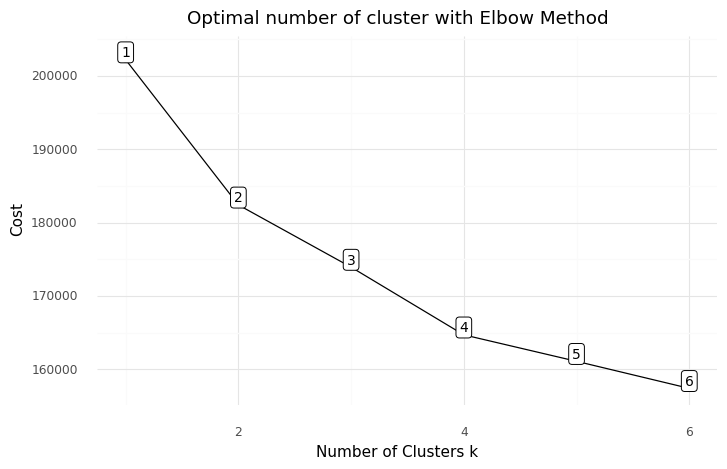

<ggplot: (122534971892)>

In [24]:
# Elbow 메소드 시각화
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster':range(1, 7), 'Cost':cost})
# Data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

- 위의 결과 3번이 제일 좋아 보임

In [25]:
df_cost

,Cluster,Cost
0,1,202206.340495
1,2,182417.010644
2,3,173936.348729
3,4,164711.244092
4,5,161104.365039
5,6,157417.209356


- 우선 3을 군집개수로 선택

# 군집개수 선택 후 모델 적합하기

In [26]:
# Fit the cluster
# n_clusters = 4으로 한다
kprototype = KPrototypes(n_clusters = 4, init = 'Huang',
                                 random_state = 0, verbose = True)
kprototype.fit_predict(dfmatrix, categorical = catcol)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 83453, ncost: 169546.69689663884
Run: 1, iteration: 2/100, moves: 26, ncost: 169546.69519254952
Run: 1, iteration: 3/100, moves: 3, ncost: 169546.6951901107
Run: 1, iteration: 4/100, moves: 0, ncost: 169546.6951901107
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 102076, ncost: 171391.94671734754
Run: 2, iteration: 2/100, moves: 16679, ncost: 171301.62434601004
Run: 2, iteration: 3/100, moves: 2587, ncost: 171301.18085172074
Run: 2, iteration: 4/100, moves: 0, ncost: 171301.18085172074
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 58221, ncost: 168123.40219772412
Run: 3, iteration: 2/100, moves: 41729, ncost: 164711.9960475156
Run: 3, iteration: 3/100, moves: 9744, ncost: 164711.24409211986
Run: 3, iteration: 4/100, moves: 0, ncost: 164711.244

array([0, 2, 1, ..., 0, 0, 1], dtype=uint16)

# 기존 데이터 프레임에 분류된 군집 추가하기

In [37]:
df4['구매월'] = df4['구매일자'].map(lambda x: str(x)[4:6]+'월')

In [30]:
#new column for cluster labels associated with each subject
df4['cluster'] = kprototype.labels_ # 모든 컬럼 들어있는 데이터프레임에 군집 추가
ndf4['cluster'] = kprototype.labels_ # 군집화에 사용된 컬럼 들어있는 데이터프레임에 군집 추가

In [34]:
# 데이터 csv파일로 저장
df4.to_csv("pdde_offline_all_4.csv", index=False, encoding="utf-8-sig")
ndf4.to_csv("pdde_offline_cateogric_4.csv", index=False, encoding="utf-8-sig")

In [36]:
ndf4.head()

,성별,연령대,거주지분류대코드,제휴사,상품대분류명,구매시간,구매금액,구매수량,구매월,cluster
0,여성,40대,Z10,A02,축산물,0.695652,0.000480,0.0,08월,0
1,여성,40대,Z10,A02,유제품,0.956522,0.000122,0.0,12월,2
2,여성,30대,Z11,A01,스포츠패션,0.695652,0.003046,0.0,09월,1
3,여성,40대,Z13,A02,완구,0.652174,0.003683,0.0,12월,2
4,여성,50대,Z10,A02,음료,0.869565,0.000144,0.0,06월,1


In [ ]:
# 저장한 데이터 불러오기
# df4 = pd.read_csv('pdde_online_all.csv', encoding='utf-8')
# df4.tail()

In [37]:
ndf4 = pd.read_csv('pdde_online_cateogric.csv', encoding='utf-8')
ndf4.tail()

,성별,연령대,거주지분류대코드,제휴사,상품대분류명,구매시간,구매금액,구매수량,구매월,cluster
299995,여성,40대,Z10,A01,화장품/뷰티케어,0.652174,0.000484,0.0,07월,0
299996,여성,60대,Z10,A03,채소,0.695652,0.000028,0.0,04월,0
299997,여성,20대,Z08,A02,채소,0.652174,0.000015,0.0,04월,1
299998,남성,50대,Z10,A02,유제품,0.782609,0.000031,0.0,02월,0
299999,남성,40대,Z17,A02,대용식,0.869565,0.000053,0.0,05월,2


In [38]:
ndf4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   성별        300000 non-null  object 
 1   연령대       300000 non-null  object 
 2   거주지분류대코드  300000 non-null  object 
 3   제휴사       300000 non-null  object 
 4   상품대분류명    300000 non-null  object 
 5   구매시간      300000 non-null  float64
 6   구매금액      300000 non-null  float64
 7   구매수량      300000 non-null  float64
 8   구매월       300000 non-null  object 
 9   cluster   300000 non-null  int64  
dtypes: float64(3), int64(1), object(6)
memory usage: 22.9+ MB


In [39]:
# 카테고리컬 변수들의 최빈값 확인
ndf4[['성별', '연령대', '거주지분류대코드', '제휴사', '상품대분류명', '구매월', 'cluster']].groupby('cluster').agg([pd.Series.mode]).T

,cluster,0,1,2
성별,mode,여성,여성,남성
연령대,mode,40대,30대,40대
거주지분류대코드,mode,Z10,Z17,Z17
제휴사,mode,A02,A02,A02
상품대분류명,mode,과자,유제품,과자
구매월,mode,01월,01월,07월


In [ ]:
plt.rcParams['font.family'] = 'Malgun Gothic'

In [ ]:
# 군집 나누기
online_0 = ndf2[ndf2['cluster'] == 0]
online_1 = ndf2[ndf2['cluster'] == 1]
online_2 = ndf2[ndf2['cluster'] == 2]

In [ ]:
# 군집별 성별 비교 
plt.figure(figsize=(17,5))
plt.subplot(131)
a=sns.countplot(x='성별', data=online_0)
a.set(title = "group 0")
plt.subplot(132)
b=sns.countplot(x='성별', data=online_1)
b.set(title = "group 1")
plt.subplot(133)
c=sns.countplot(x='성별', data=online_2)
c.set(title = "group 2")

- 성별로는 군집별로 유의미한 차이 없었음

In [ ]:
# 연령대
plt.figure(figsize=(17,5))
plt.subplot(131)
a=sns.countplot(x='연령대', data=online_0, order = online_0['연령대'].value_counts().index)
a.set(title = "group 0")
plt.subplot(132)
b=sns.countplot(x='연령대', data=online_1, order = online_1['연령대'].value_counts().index)
b.set(title = "group 1")
plt.subplot(133)
c=sns.countplot(x='연령대', data=online_2, order = online_2['연령대'].value_counts().index)
c.set(title = "group 2")

- 연령대의 경우 group 0,1은 주로 4-50대, 2는 3-40대

In [ ]:
# 거주지분류대코드
plt.figure(figsize=(17,5))
plt.subplot(131)
a=sns.countplot(x='거주지분류대코드', data=online_0, order = online_0['거주지분류대코드'].value_counts().index)
a.set(title = "group 0")
plt.subplot(132)
b=sns.countplot(x='거주지분류대코드', data=online_1, order = online_1['거주지분류대코드'].value_counts().index)
b.set(title = "group 1")
plt.subplot(133)
c=sns.countplot(x='거주지분류대코드', data=online_2, order = online_2['거주지분류대코드'].value_counts().index)
c.set(title = "group 2")

- 거주지의 경우 group0과 1은 대부분 Z17, group2는 대부분 10

In [ ]:
# 제휴사
plt.figure(figsize=(17,5))
plt.subplot(131)
a=sns.countplot(x='제휴사', data=online_0, order = online_0['제휴사'].value_counts().index)
a.set(title = "group 0")
plt.subplot(132)
b=sns.countplot(x='제휴사', data=online_1, order = online_1['제휴사'].value_counts().index)
b.set(title = "group 1")
plt.subplot(133)
c=sns.countplot(x='제휴사', data=online_2, order = online_2['제휴사'].value_counts().index)
c.set(title = "group 2")

- group0은 주 제휴사가 A03, A02, A06 순
- group1,2는 주 제휴사가 A02, A06, A03 순 

In [ ]:
# 상품대분류명
plt.figure(figsize=(17,5))
plt.subplot(131)
a=sns.countplot(x='상품대분류명', data=online_0, order = online_0['상품대분류명'].value_counts().index[:7])
a.set(title = "group 0")
plt.subplot(132)
b=sns.countplot(x='상품대분류명', data=online_1, order = online_1['상품대분류명'].value_counts().index[:7])
b.set(title = "group 1")
plt.subplot(133)
c=sns.countplot(x='상품대분류명', data=online_2, order = online_2['상품대분류명'].value_counts().index[:7])
c.set(title = "group 2")

- group0는 축산물, 채소, 유제품, 과자, 과일, 음료, 냉장식품 순 -> 축산물, 채소와 같이 주로 저녁식사?
- group1은 대용식, 유제품, 과자, 채소, 과일, 음료, 조미료 순 -> 대용식(압도적으로 많이 구매), 유제품, 과자와 같이 주로 간편하게 먹을 수 있는 것들
- group2는 채소, 과자, 유제품, 과일, 음료, 축산물, 냉장식품 순 -> 채소를 압도적으로 많이 구매

In [ ]:
# 구매월
plt.figure(figsize=(17,5))
plt.subplot(131)
a=sns.countplot(x='구매월', data=online_0, order = online_0['구매월'].value_counts().index)
a.set(title = "group 0")
plt.subplot(132)
b=sns.countplot(x='구매월', data=online_1, order = online_1['구매월'].value_counts().index)
b.set(title = "group 1")
plt.subplot(133)
c=sns.countplot(x='구매월', data=online_2, order = online_2['구매월'].value_counts().index)
c.set(title = "group 2")

- 모든 그룹 모두 상반기에 구매 많이하는 경향
- 그중에서도 group1은 특히 1월에, group1은 2월에, group3는 4월에 구매를 많이하는 경향.
- 다른 그룹보다 group0은 비교적 하반기에도 구매 많이 하는 편

In [ ]:
# 숫자형 변수는 df2로 분석 (스케일링 해줬기 때문)
df2[['구매시간', '구매금액', '구매수량', 'cluster']].groupby('cluster').agg(['mean', 'median']).T

- 구매시간 : group0은 주로 4시경, group1은 주로 오전 11시경, group2는 주로 오후 2시경 구매
- 구매금액 : group0가 평균 약 18300원 중앙값 5880원 / group1은 평균 약 16470원 중앙값 4980원 / group2는 평균 약 16930원, 중앙값 4380원으로 group0가 group1,2에 비해 더 금액이 큼
- 구매수량 : 모두 다 비슷

In [ ]:
online0 = df2[df2['cluster'] == 0]
online1 = df2[df2['cluster'] == 1]
online2 = df2[df2['cluster'] == 2]

In [ ]:
# 구매시간은 따로 확인해보기
plt.figure(figsize=(17,5))
plt.subplot(131)
a=sns.countplot(x='구매시간', data=online0, order = online0['구매시간'].value_counts().index[:7])
a.set(title = "group 0")
plt.subplot(132)
b=sns.countplot(x='구매시간', data=online1, order = online1['구매시간'].value_counts().index[:7])
b.set(title = "group 1")
plt.subplot(133)
c=sns.countplot(x='구매시간', data=online2, order = online2['구매시간'].value_counts().index[:7])
c.set(title = "group 2")

- group 0 : 저녁, group 1 : 오전, group 2 : 오후 (낮)